HYDRAULIC SYSTEM CONDITION MONITORING - DECISION TREE APPROACH

Dataset shape: (2205, 22)
Number of samples: 2205
Number of features: 17


######################################################################
# TRAINING MODEL FOR: Cooler_Condition
######################################################################

Class distribution:
Cooler_Condition
3      732
20     732
100    741
Name: count, dtype: int64

──────────────────────────────────────────────────────────────────────
Training Decision Tree Model...
──────────────────────────────────────────────────────────────────────
✓ Training completed!

RESULTS FOR: Cooler_Condition

Training Set Metrics:
  Accuracy:  0.9938
  Precision: 0.9938
  Recall:    0.9938
  F1-Score:  0.9938

Test Set Metrics:
  Accuracy:  0.9841
  Precision: 0.9846
  Recall:    0.9841
  F1-Score:  0.9841

✓ Good generalization (gap: 0.0096)

──────────────────────────────────────────────────────────────────────
Cross-Validation (5-fold):
─────────────────

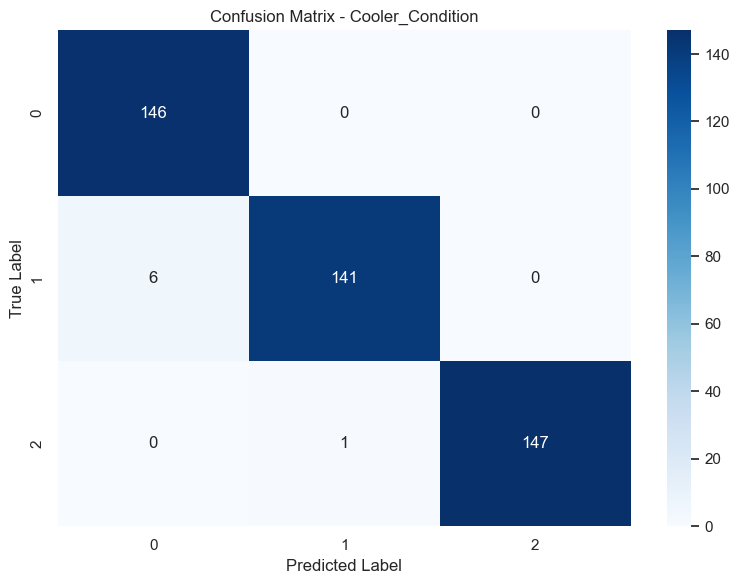

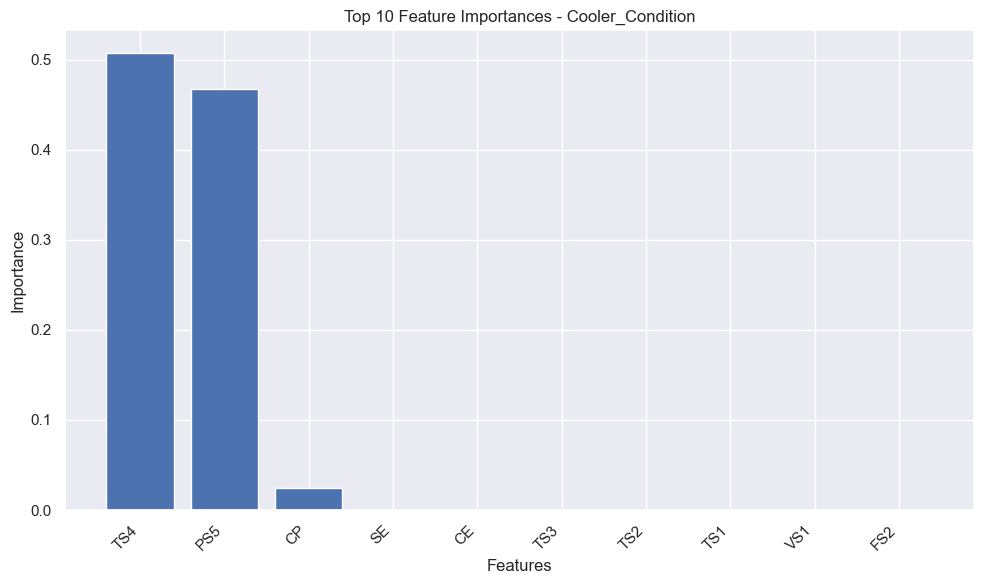

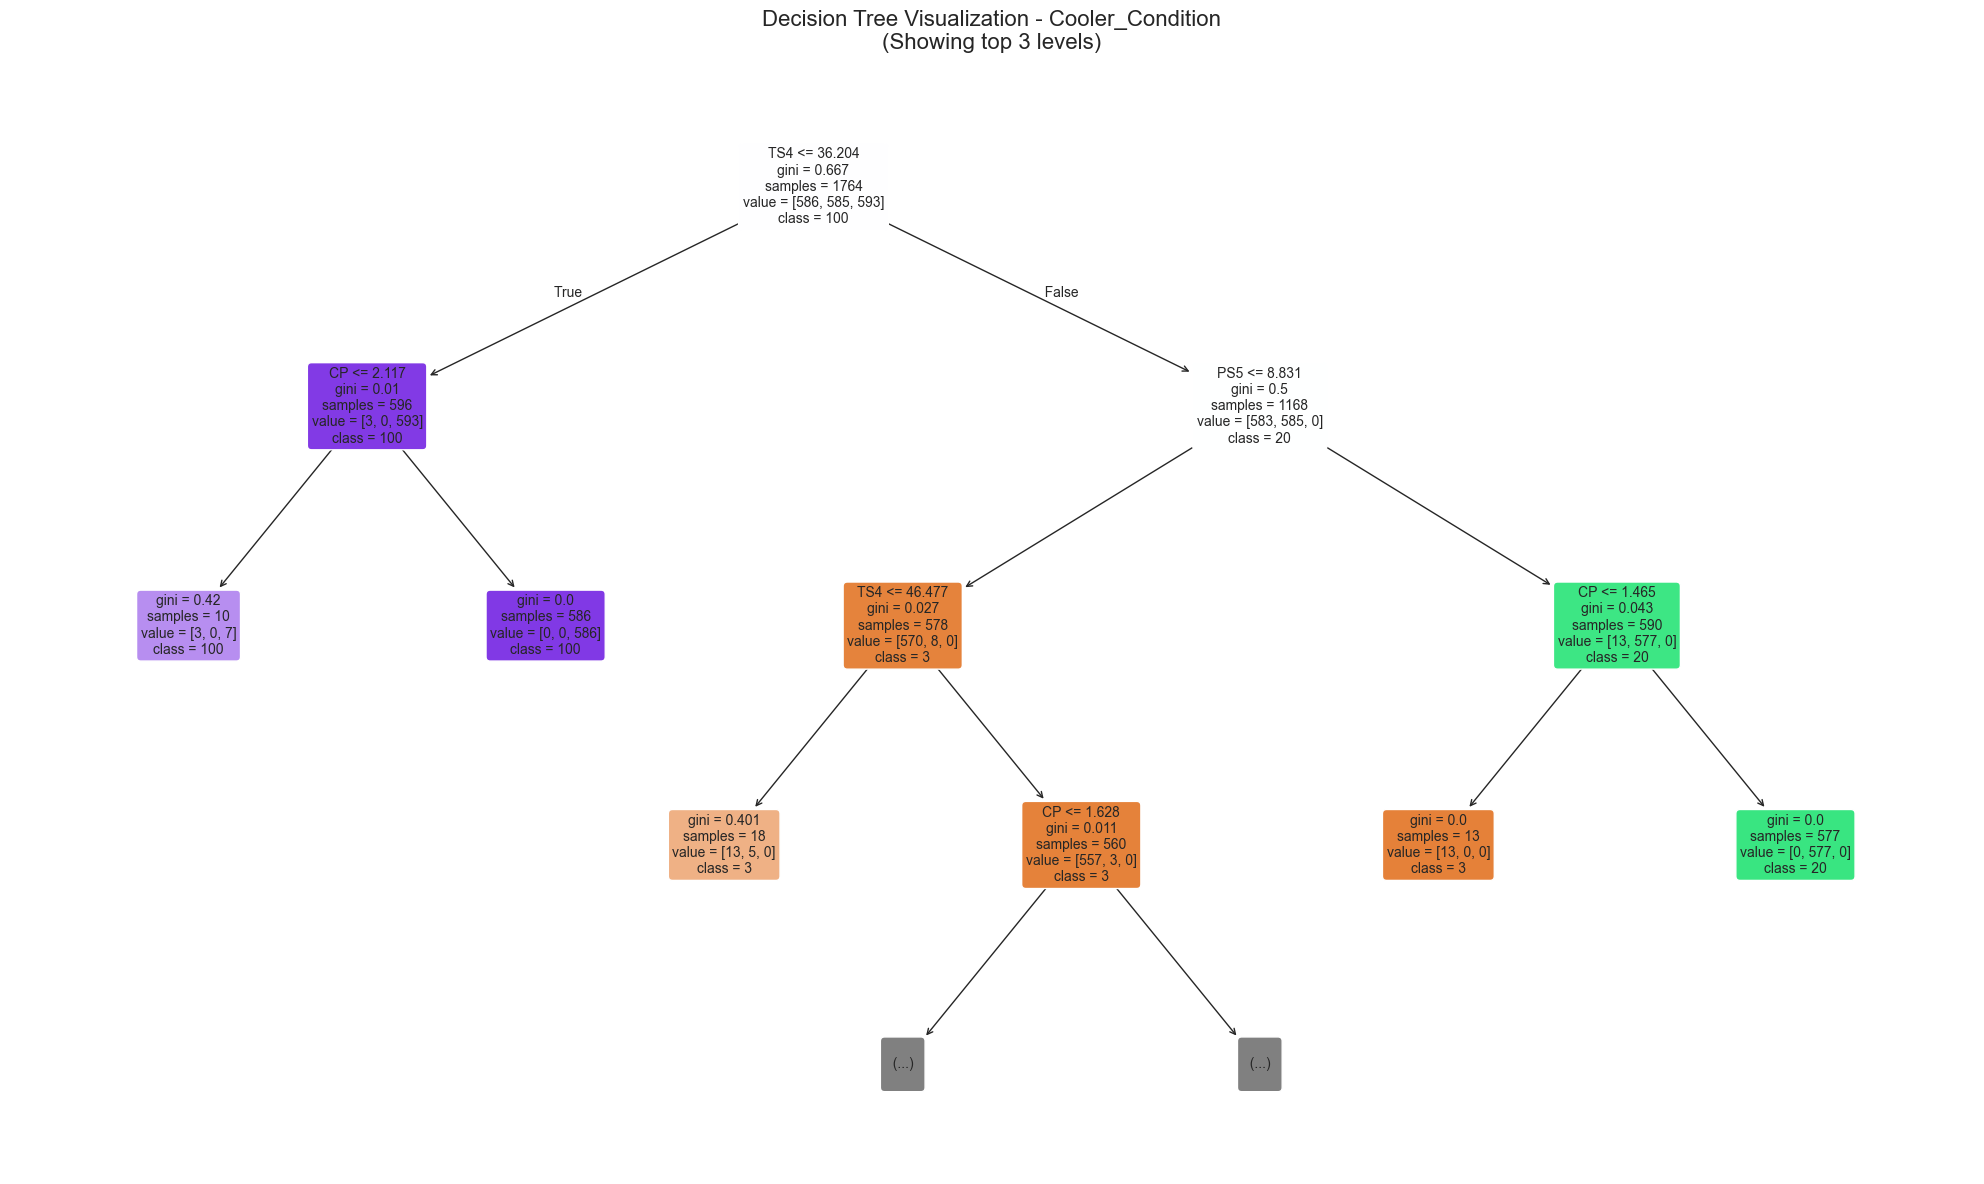

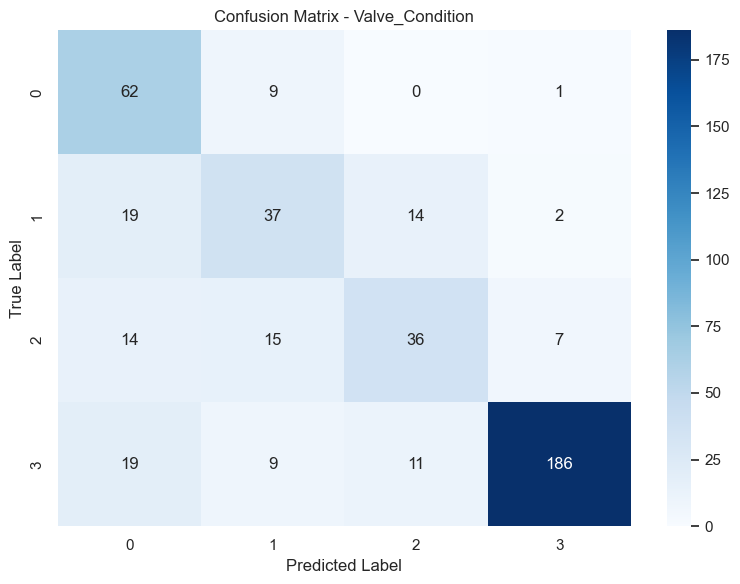

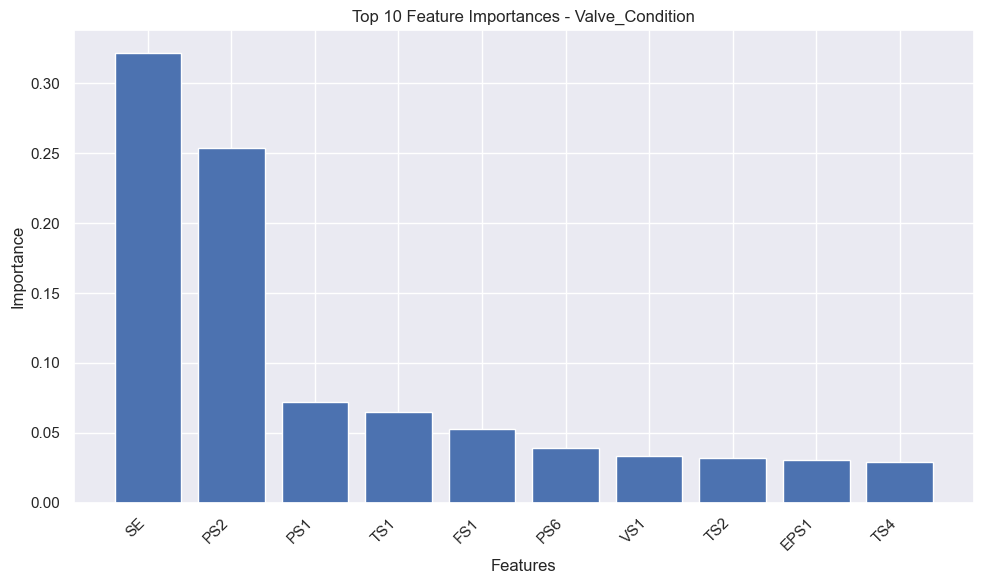

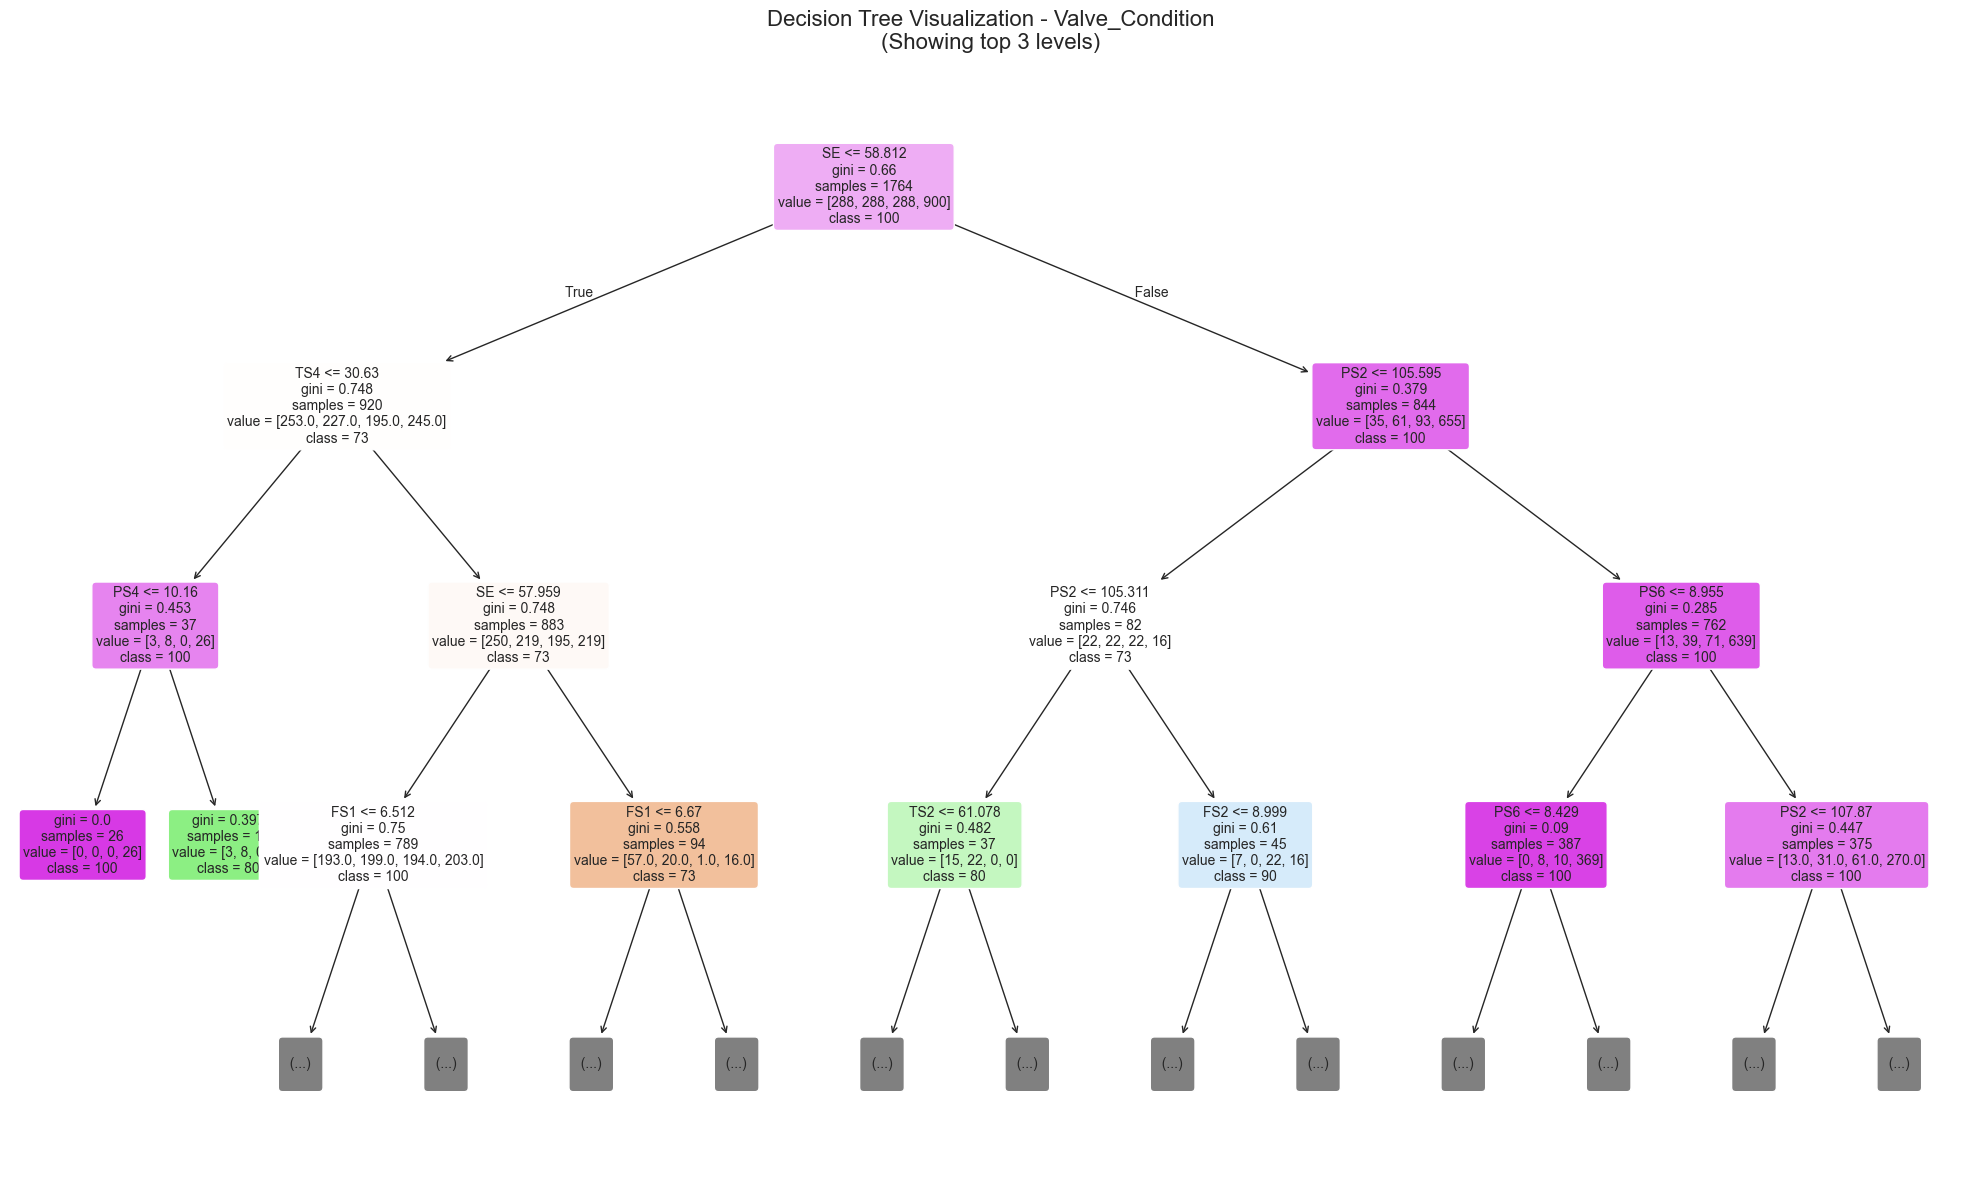

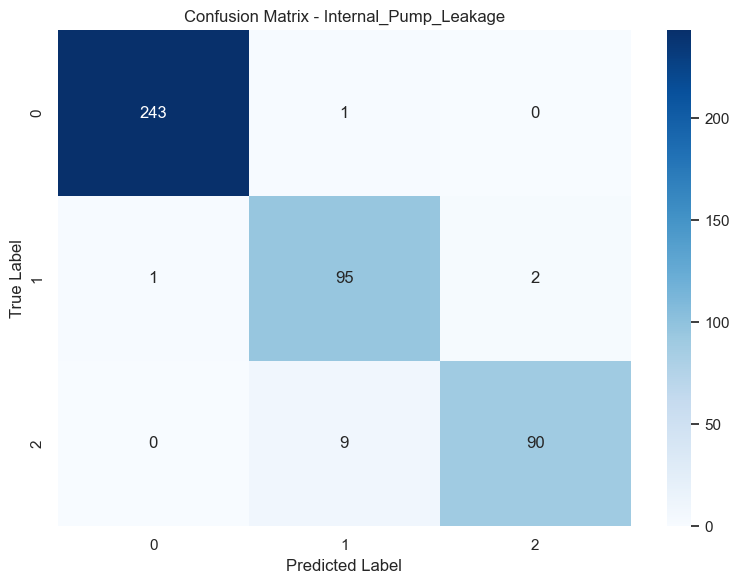

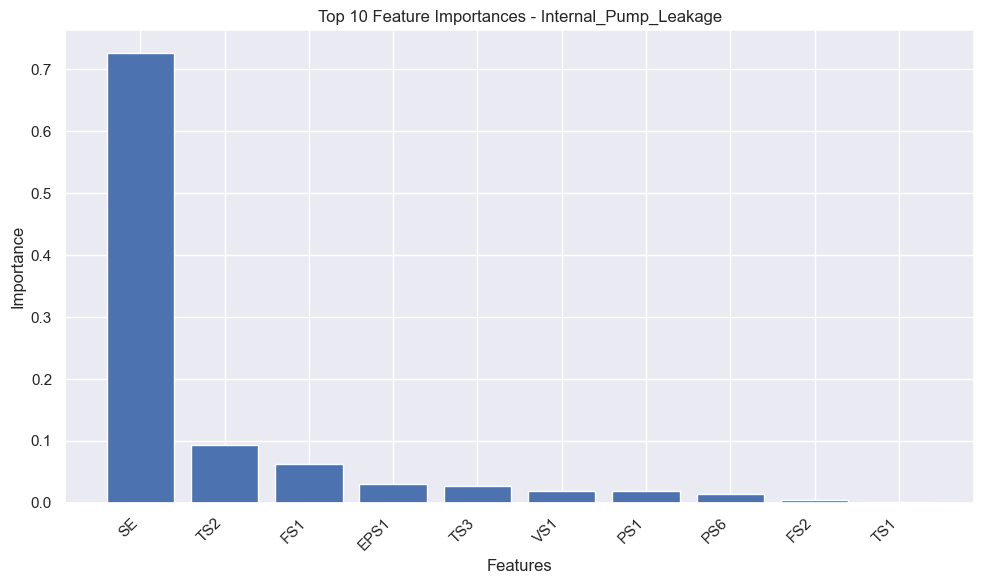

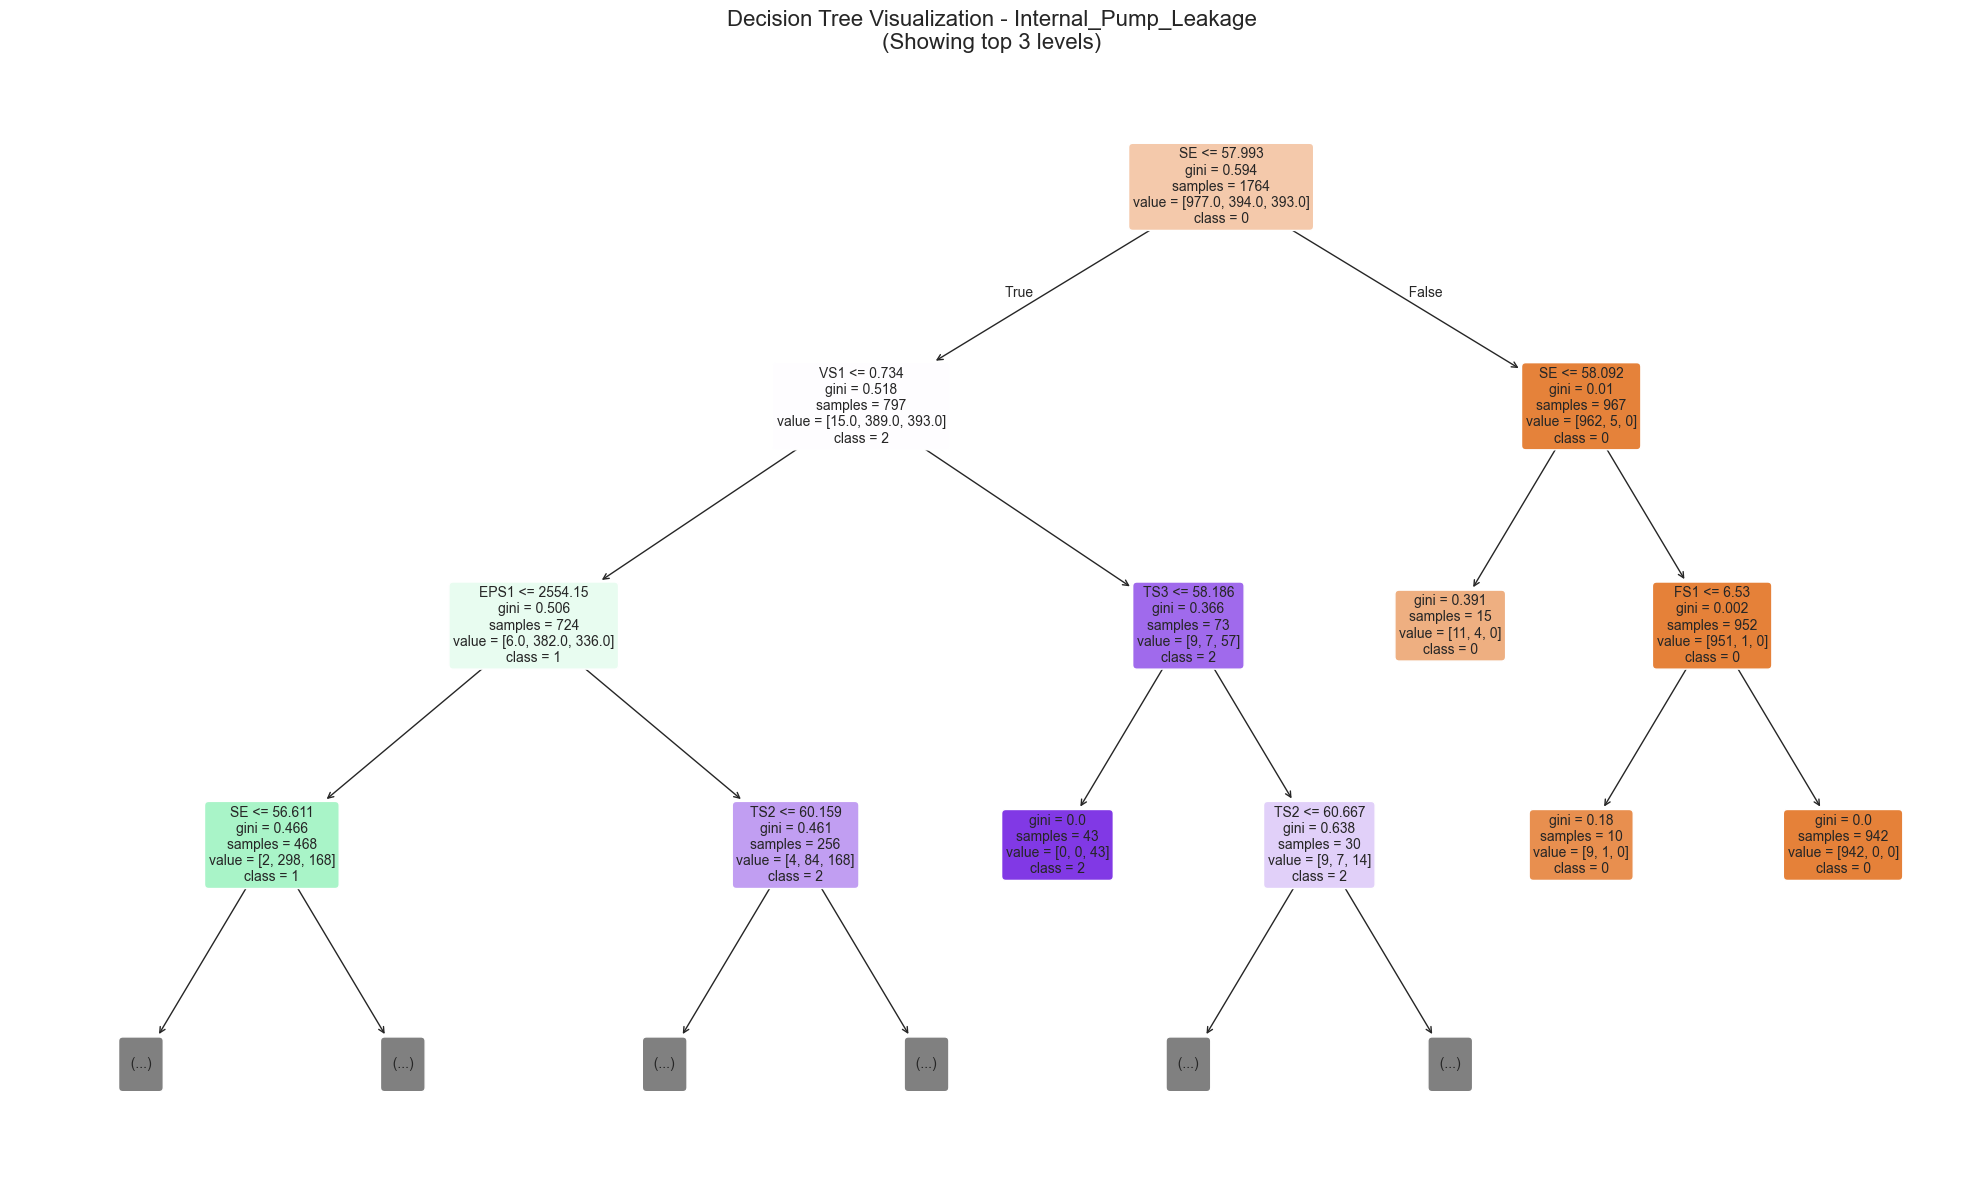

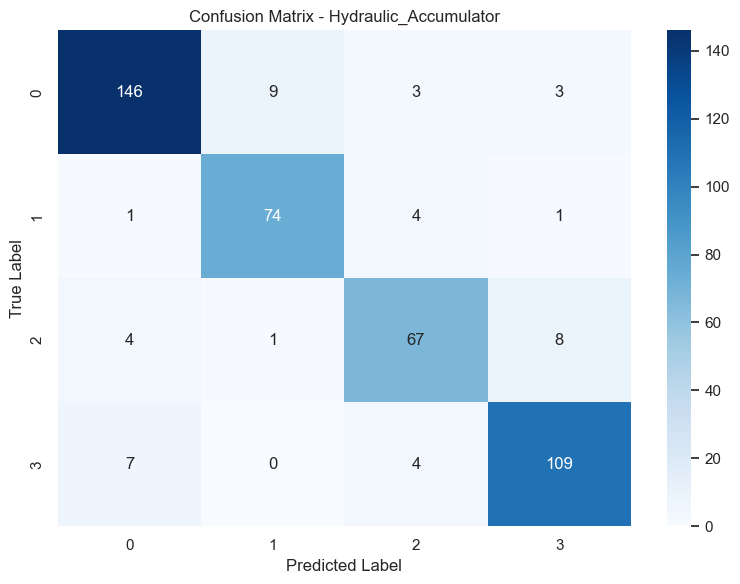

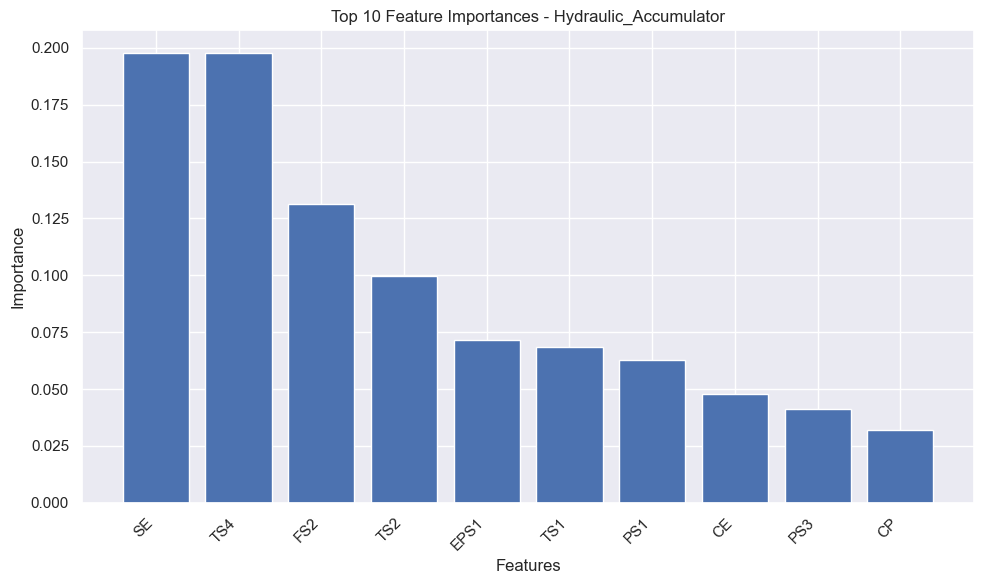

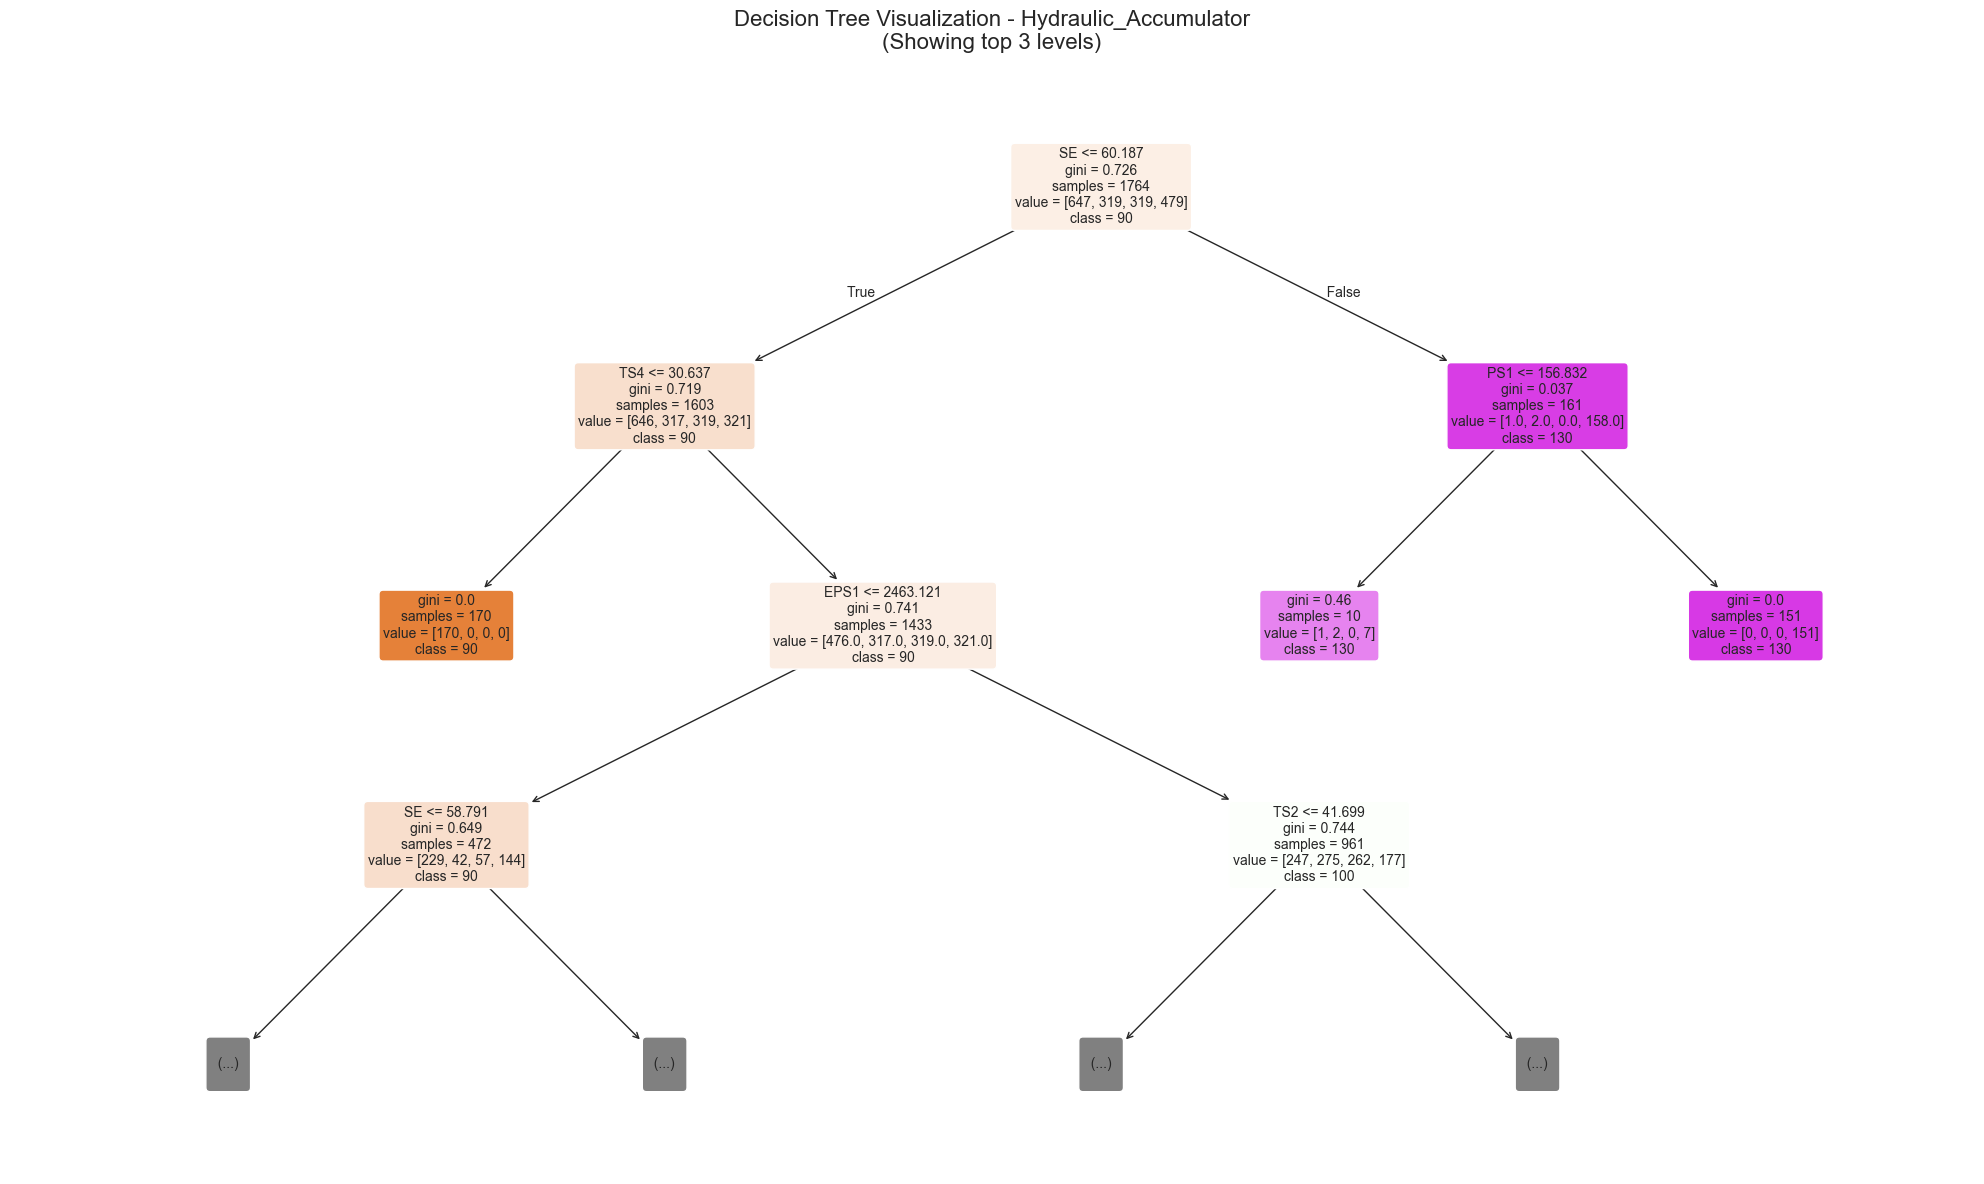

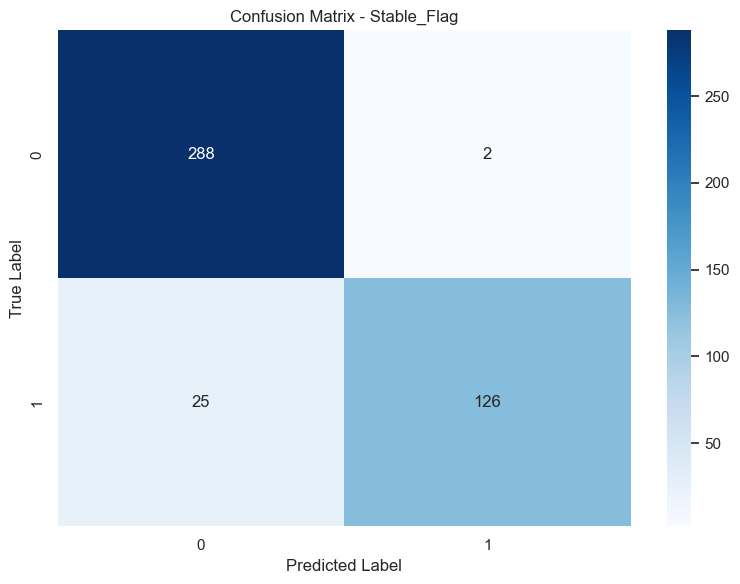

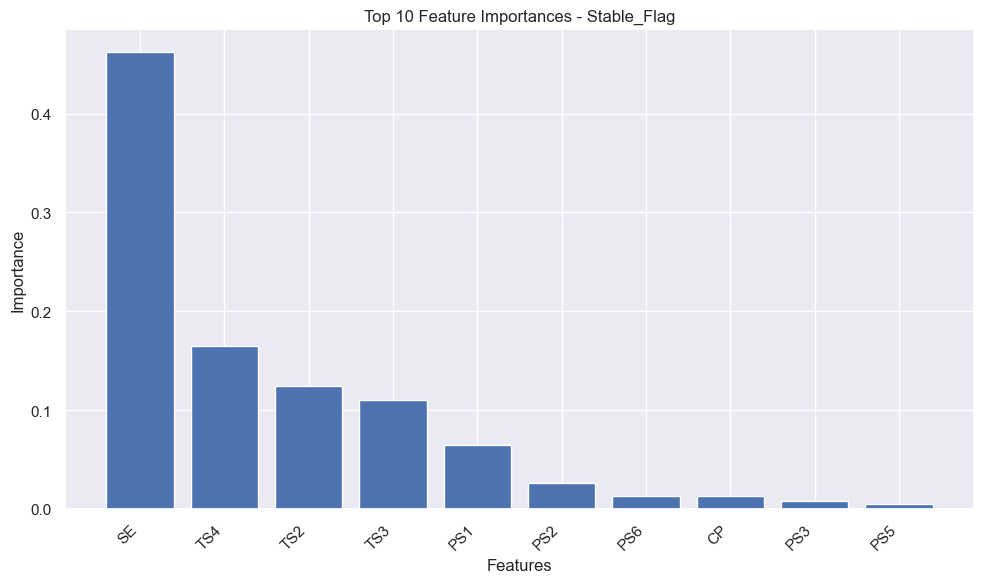

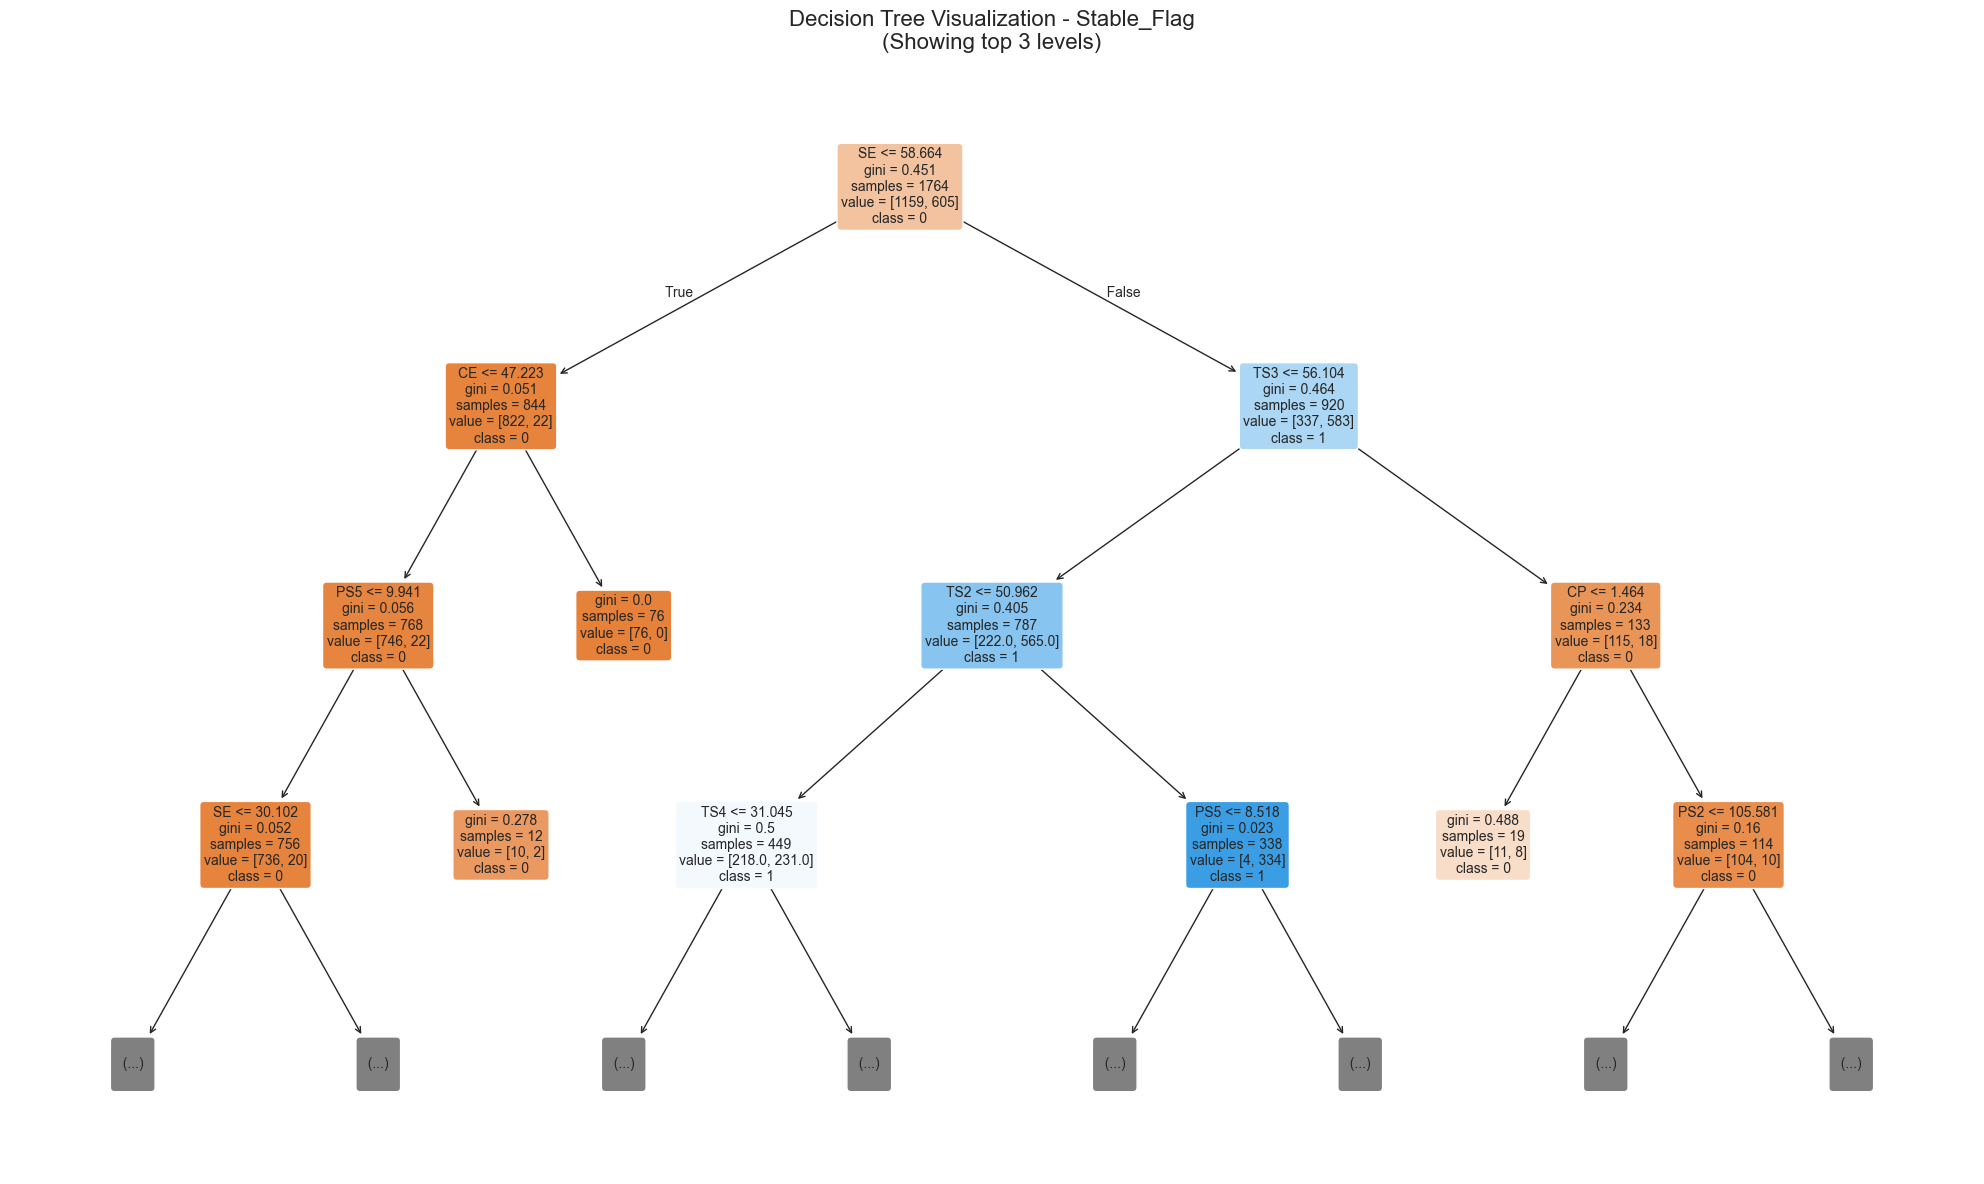

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

# Set style
sns.set(color_codes=True)
plt.rcParams['figure.figsize'] = (15, 10)

# ============================================================================
# 1. DATA PREPARATION
# ============================================================================

print("="*70)
print("HYDRAULIC SYSTEM CONDITION MONITORING - DECISION TREE APPROACH")
print("="*70)

# Download and extract data (if needed)
# !wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00447/data.zip"
# !unzip -o "data.zip"

# Import sensor values as features
sensor_names = ["PS1", "PS2", "PS3", "PS4", "PS5", "PS6",
                "EPS1", "FS1", "FS2", "TS1", "TS2", "TS3",
                "TS4", "VS1", "CE", "CP", "SE"]

feature_list = []
for sensor in sensor_names:
    data = np.genfromtxt(f"{sensor}.txt")
    feature_list.append(data)

# Extract mean values
feature_means = {}
for i in range(len(sensor_names)):
    feature_means[sensor_names[i]] = feature_list[i].mean(axis=1)

# Create features dataframe
df_features = pd.DataFrame(feature_means)

# Import target labels
target = np.genfromtxt(r"profile.txt")
df_targets = pd.DataFrame(target, columns=[
    "Cooler_Condition",
    "Valve_Condition",
    "Internal_Pump_Leakage",
    "Hydraulic_Accumulator",
    "Stable_Flag"
])

# Combine features and targets
df_final = pd.concat([df_features, df_targets], axis=1)

print(f"\nDataset shape: {df_final.shape}")
print(f"Number of samples: {len(df_final)}")
print(f"Number of features: {len(sensor_names)}")

# Prepare features and targets
X = df_final.iloc[:, :-5]
targets = {
    'Cooler_Condition': df_final['Cooler_Condition'].astype(int),
    'Valve_Condition': df_final['Valve_Condition'].astype(int),
    'Internal_Pump_Leakage': df_final['Internal_Pump_Leakage'].astype(int),
    'Hydraulic_Accumulator': df_final['Hydraulic_Accumulator'].astype(int),
    'Stable_Flag': df_final['Stable_Flag'].astype(int)
}

# ============================================================================
# 2. HELPER FUNCTIONS
# ============================================================================

def evaluate_model(model, X_train, X_test, y_train, y_test, target_name):
    """Comprehensive model evaluation"""

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_precision = precision_score(y_train, y_pred_train, average='weighted')
    test_precision = precision_score(y_test, y_pred_test, average='weighted')
    train_recall = recall_score(y_train, y_pred_train, average='weighted')
    test_recall = recall_score(y_test, y_pred_test, average='weighted')
    train_f1 = f1_score(y_train, y_pred_train, average='weighted')
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')

    print(f"\n{'='*70}")
    print(f"RESULTS FOR: {target_name}")
    print(f"{'='*70}")
    print(f"\nTraining Set Metrics:")
    print(f"  Accuracy:  {train_accuracy:.4f}")
    print(f"  Precision: {train_precision:.4f}")
    print(f"  Recall:    {train_recall:.4f}")
    print(f"  F1-Score:  {train_f1:.4f}")

    print(f"\nTest Set Metrics:")
    print(f"  Accuracy:  {test_accuracy:.4f}")
    print(f"  Precision: {test_precision:.4f}")
    print(f"  Recall:    {test_recall:.4f}")
    print(f"  F1-Score:  {test_f1:.4f}")

    # Check for overfitting
    overfit_gap = train_accuracy - test_accuracy
    if overfit_gap > 0.1:
        print(f"\n⚠️  Warning: Possible overfitting detected (gap: {overfit_gap:.4f})")
    else:
        print(f"\n✓ Good generalization (gap: {overfit_gap:.4f})")

    return {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_precision': train_precision,
        'test_precision': test_precision,
        'predictions': y_pred_test
    }

def plot_confusion_matrix(y_true, y_pred, target_name):
    """Plot confusion matrix"""
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title(f'Confusion Matrix - {target_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{target_name.replace(" ", "_")}.png', dpi=300)
    print(f"\n✓ Confusion matrix saved as 'confusion_matrix_{target_name.replace(' ', '_')}.png'")

def plot_decision_tree(model, feature_names, class_names, target_name, max_depth=3):
    """Visualize decision tree"""
    plt.figure(figsize=(20, 12))
    plot_tree(
        model,
        feature_names=feature_names,
        class_names=[str(c) for c in class_names],
        filled=True,
        rounded=True,
        fontsize=10,
        max_depth=max_depth  # Limit depth for readability
    )
    plt.title(f'Decision Tree Visualization - {target_name}\n(Showing top {max_depth} levels)',
              fontsize=16, pad=20)
    plt.tight_layout()
    plt.savefig(f'decision_tree_{target_name.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    print(f"✓ Decision tree saved as 'decision_tree_{target_name.replace(' ', '_')}.png'")

def plot_feature_importance(model, feature_names, target_name, top_n=10):
    """Plot feature importance"""
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]

    plt.figure(figsize=(10, 6))
    plt.title(f'Top {top_n} Feature Importances - {target_name}')
    plt.bar(range(top_n), importances[indices])
    plt.xticks(range(top_n), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.tight_layout()
    plt.savefig(f'feature_importance_{target_name.replace(" ", "_")}.png', dpi=300)
    print(f"✓ Feature importance saved as 'feature_importance_{target_name.replace(' ', '_')}.png'")

    print(f"\nTop {top_n} Most Important Features:")
    for i, idx in enumerate(indices, 1):
        print(f"  {i}. {feature_names[idx]}: {importances[idx]:.4f}")

# ============================================================================
# 3. TRAIN DECISION TREE MODELS FOR ALL TARGETS
# ============================================================================

results_summary = {}

for target_name, y in targets.items():

    print(f"\n\n{'#'*70}")
    print(f"# TRAINING MODEL FOR: {target_name}")
    print(f"{'#'*70}")

    # Check class distribution
    print(f"\nClass distribution:")
    print(y.value_counts().sort_index())

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1, stratify=y
    )

    # ========================================================================
    # DECISION TREE MODEL
    # ========================================================================

    # Create decision tree classifier
    dt_model = DecisionTreeClassifier(
        max_depth=10,              # Limit depth to prevent overfitting
        min_samples_split=20,      # Minimum samples required to split
        min_samples_leaf=10,       # Minimum samples required at leaf
        max_features='sqrt',       # Number of features to consider
        random_state=1,
        criterion='gini'           # Use Gini impurity
    )

    # Train the model
    print(f"\n{'─'*70}")
    print("Training Decision Tree Model...")
    print(f"{'─'*70}")
    dt_model.fit(X_train, y_train)
    print("✓ Training completed!")

    # Evaluate model
    results = evaluate_model(dt_model, X_train, X_test, y_train, y_test, target_name)
    results_summary[target_name] = results

    # Cross-validation
    print(f"\n{'─'*70}")
    print("Cross-Validation (5-fold):")
    print(f"{'─'*70}")
    cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"  CV Accuracy Scores: {cv_scores}")
    print(f"  Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

    # Visualizations
    print(f"\n{'─'*70}")
    print("Generating Visualizations...")
    print(f"{'─'*70}")

    # 1. Confusion Matrix
    plot_confusion_matrix(y_test, results['predictions'], target_name)

    # 2. Feature Importance
    plot_feature_importance(dt_model, X.columns.tolist(), target_name, top_n=10)

    # 3. Decision Tree Visualization (only for first 3 levels)
    class_names = sorted(y.unique())
    plot_decision_tree(dt_model, X.columns.tolist(), class_names, target_name, max_depth=3)

    # Classification Report
    print(f"\n{'─'*70}")
    print("Detailed Classification Report:")
    print(f"{'─'*70}")
    print(classification_report(y_test, results['predictions']))

    # Model complexity metrics
    print(f"\n{'─'*70}")
    print("Model Complexity:")
    print(f"{'─'*70}")
    print(f"  Tree Depth: {dt_model.get_depth()}")
    print(f"  Number of Leaves: {dt_model.get_n_leaves()}")
    print(f"  Number of Features Used: {np.sum(dt_model.feature_importances_ > 0)}")

# ============================================================================
# 4. SUMMARY OF ALL MODELS
# ============================================================================

print(f"\n\n{'='*70}")
print("OVERALL SUMMARY - ALL TARGETS")
print(f"{'='*70}\n")

summary_df = pd.DataFrame({
    target: {
        'Train Accuracy': f"{results['train_accuracy']:.4f}",
        'Test Accuracy': f"{results['test_accuracy']:.4f}",
        'Train Precision': f"{results['train_precision']:.4f}",
        'Test Precision': f"{results['test_precision']:.4f}"
    }
    for target, results in results_summary.items()
}).T

print(summary_df)

# Best and worst performing models
print(f"\n{'─'*70}")
test_accuracies = {k: v['test_accuracy'] for k, v in results_summary.items()}
best_model = max(test_accuracies, key=test_accuracies.get)
worst_model = min(test_accuracies, key=test_accuracies.get)

print(f"Best Performing Model: {best_model} ({test_accuracies[best_model]:.4f})")
print(f"Worst Performing Model: {worst_model} ({test_accuracies[worst_model]:.4f})")

# ============================================================================
# 5. SAVE FINAL MODELS (Optional)
# ============================================================================

print(f"\n{'─'*70}")
print("Saving Models...")
print(f"{'─'*70}")

import pickle

for target_name, y in targets.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1, stratify=y
    )

    # Train final model on all training data
    final_model = DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        max_features='sqrt',
        random_state=1
    )
    final_model.fit(X_train, y_train)

    # Save model
    filename = f'dt_model_{target_name.replace(" ", "_")}.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(final_model, f)
    print(f"✓ Model saved: {filename}")

print(f"\n{'='*70}")
print("ALL PROCESSING COMPLETE!")
print(f"{'='*70}")